In [1]:
import torch
import torch.utils.cpp_extension
from pathlib import Path
import random
import triton
import triton.language as tl

In [2]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [3]:
def test_correctness(softmax_impl, repeats=100):
    for i in range(repeats):
        row = random.randint(1, 1024 * 32)
        cols = random.randint(1, 1024 * 32)
        a = torch.randn((row, cols), device="cuda", dtype=torch.float32)
        torch.testing.assert_close(softmax_impl(a), torch.nn.functional.softmax(a, dim=-1), msg=f"row = {row}, cols = {cols}")
    return softmax_impl

In [4]:
test_correctness(lambda a: torch.nn.functional.softmax(a, dim=-1))

<function __main__.<lambda>(a)>

In [5]:
def load_cuda_impl(file_name):
    cuda_src = Path(file_name).read_text()
    cpp_src = """
    torch::Tensor softmax(const torch::Tensor& x);
    """
    my = torch.utils.cpp_extension.load_inline(
        "my", cpp_src, cuda_src,
        functions=['softmax'], extra_cuda_cflags=['--ptxas-options=-v'], verbose=True,
    )
    return my.softmax

In [6]:
kernels = {}

In [7]:
def add_kernel(name, kernel):
    kernels[name] = kernel

In [8]:
add_kernel("Torch", torch.nn.functional.softmax)

## Naive

In [9]:
def naive_pytorch_softmax(x, dim=None):
    m = torch.max(x, dim=dim, keepdim=True)[0]
    e = torch.exp(x - m)
    s = torch.sum(e, dim=dim, keepdim=True)
    return e / s

In [10]:
add_kernel("Naive", test_correctness(lambda a: naive_pytorch_softmax(a, dim=-1)))

In [11]:
@torch.compile
def compiled_naive_pytorch_softmax(x, dim=None):
    return naive_pytorch_softmax(x, dim=dim)

In [12]:
add_kernel("CompiledNaive", test_correctness(lambda a: compiled_naive_pytorch_softmax(a, dim=-1)))

## CUDA

In [13]:
softmax1 = add_kernel("CUDA1", test_correctness(load_cuda_impl("softmax1.cu")))

Using /home/belevich/.cache/torch_extensions/py312_cu126 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/belevich/.cache/torch_extensions/py312_cu126/my/build.ninja...
/fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module my...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=my -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /fsxl/belevich/miniconda3/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -c /home/belevich/.cache/torch_extensions/py312_cu126/my/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=my -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include/tor

Loading extension module my...


In [14]:
softmax2 = add_kernel("CUDA2", test_correctness(load_cuda_impl("softmax2.cu")))

Using /home/belevich/.cache/torch_extensions/py312_cu126 as PyTorch extensions root...
The input conditions for extension module my have changed. Bumping to version 1 and re-building as my_v1...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/belevich/.cache/torch_extensions/py312_cu126/my/build.ninja...
/fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module my_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=my_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /fsxl/belevich/miniconda3/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -c /home/belevich/.cache/torch_extensions/py312_cu126/my/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=my_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/inclu

Loading extension module my_v1...


In [15]:
softmax2_shfl = add_kernel("CUDA2_SHFL", test_correctness(load_cuda_impl("softmax2_shfl.cu")))

Using /home/belevich/.cache/torch_extensions/py312_cu126 as PyTorch extensions root...
The input conditions for extension module my have changed. Bumping to version 2 and re-building as my_v2...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/belevich/.cache/torch_extensions/py312_cu126/my/build.ninja...
/fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module my_v2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=my_v2 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /fsxl/belevich/miniconda3/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -c /home/belevich/.cache/torch_extensions/py312_cu126/my/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=my_v2 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/inclu

Loading extension module my_v2...


In [16]:
# softmax3 = add_kernel("CUDA3", test_correctness(load_cuda_impl("softmax3.cu")))

In [17]:
softmax3_shfl = add_kernel("CUDA3_SHFL", test_correctness(load_cuda_impl("softmax3_shfl.cu")))

Using /home/belevich/.cache/torch_extensions/py312_cu126 as PyTorch extensions root...
The input conditions for extension module my have changed. Bumping to version 3 and re-building as my_v3...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/belevich/.cache/torch_extensions/py312_cu126/my/build.ninja...
/fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module my_v3...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=my_v3 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /fsxl/belevich/miniconda3/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -c /home/belevich/.cache/torch_extensions/py312_cu126/my/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=my_v3 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/inclu

Loading extension module my_v3...


In [18]:
softmax5 = add_kernel("CUDA5", test_correctness(load_cuda_impl("softmax5.cu")))

Using /home/belevich/.cache/torch_extensions/py312_cu126 as PyTorch extensions root...
The input conditions for extension module my have changed. Bumping to version 4 and re-building as my_v4...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/belevich/.cache/torch_extensions/py312_cu126/my/build.ninja...
/fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module my_v4...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=my_v4 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /fsxl/belevich/miniconda3/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -c /home/belevich/.cache/torch_extensions/py312_cu126/my/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=my_v4 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/inclu

Loading extension module my_v4...


## Triton

In [19]:
@triton.jit
def triton_softmax1_kernel(
    x,
    x_row_stride,
    y,
    y_row_stride,
    n_cols,
    block_size: tl.constexpr,
):
    row_idx = tl.program_id(0)
    x_row_start = x + row_idx * x_row_stride
    col_offsets = tl.arange(0, block_size)
    row_ptrs = x_row_start + col_offsets
    mask = col_offsets < n_cols
    row = tl.load(row_ptrs, mask=mask, other=float('-inf'))

    row_max = tl.max(row, axis=0)
    safe_row = row - row_max
    exp_row = tl.exp(safe_row)
    sum_row = tl.sum(exp_row, axis=0)
    y_row_start = y + row_idx * y_row_stride
    y_ptrs = y_row_start + col_offsets
    tl.store(y_ptrs, exp_row / sum_row, mask=mask)

def triton_softmax1(x: torch.Tensor) -> torch.Tensor:
    x_flatten = x.reshape(-1, x.size(-1))
    y = torch.empty_like(x_flatten)
    rows, cols = x_flatten.shape
    block_size = triton.next_power_of_2(cols)
    num_warps = 4
    if block_size > 2047:
        num_warps = 8
    elif block_size > 4095:
        num_warps = 16

    grid = (rows, )
    triton_softmax1_kernel[grid](x_flatten, x_flatten.stride(0), y, y.stride(0), cols, block_size, num_warps=num_warps)
    
    return y.view_as(x)

add_kernel("Triton1", test_correctness(triton_softmax1))

In [20]:
@triton.jit
def triton_softmax2_kernel(
    x,
    x_row_stride,
    y,
    y_row_stride,
    n_cols,
    block_size: tl.constexpr,
):
    row_idx = tl.program_id(0)
    x_row_start = x + row_idx * x_row_stride
    y_row_start = y + row_idx * y_row_stride
    offsets = tl.arange(0, block_size)
    row_max = tl.full((), -float("inf"), dtype=tl.float32)
    for b in range(0, (n_cols + block_size - 1) // block_size):
        idx = b * block_size + offsets
        mask = idx < n_cols
        x_vals = tl.load(x_row_start + idx, mask=mask)
        row_max = tl.maximum(row_max, tl.max(x_vals.to(tl.float32)))

    row_sum = tl.zeros((), dtype=tl.float32)
    for b in range(0, (n_cols + block_size - 1) // block_size):
        idx = b * block_size + offsets
        mask = idx < n_cols
        x_vals = tl.load(x_row_start + idx, mask=mask, other=-float("inf"))
        x_vals = tl.exp(x_vals - row_max)
        row_sum += tl.sum(x_vals)
        tl.store(y_row_start + idx, x_vals, mask=mask)

    for b in range(0, (n_cols + block_size - 1) // block_size):
        idx = b * block_size + offsets
        mask = idx < n_cols
        y_vals = tl.load(y_row_start + idx, mask=mask)
        y_vals /= row_sum
        tl.store(y_row_start + idx, y_vals, mask=mask)
    

def triton_softmax2(x: torch.Tensor) -> torch.Tensor:
    x_flatten = x.reshape(-1, x.size(-1))
    y = torch.empty_like(x_flatten)
    rows, cols = x_flatten.shape
    block_size = 1024 * 32
    num_warps = 4
    if block_size > 2047:
        num_warps = 8
    elif block_size > 4095:
        num_warps = 16
    grid = (rows,)
    triton_softmax2_kernel[grid](x_flatten, x_flatten.stride(0), y, y.stride(0), cols, block_size, num_warps=num_warps)
    return y.view_as(x)

add_kernel("Triton2", test_correctness(triton_softmax2))

In [21]:
@triton.jit
def triton_softmax3_kernel(
    x,
    x_row_stride,
    y,
    y_row_stride,
    n_cols,
    block_size: tl.constexpr,
):
    row_idx = tl.program_id(0)
    x_row_start = x + row_idx * x_row_stride
    y_row_start = y + row_idx * y_row_stride
    current_max = float('-inf')
    current_sum = 0.0
    
    for block_offset in tl.range(0, n_cols, block_size):
        col_offsets = block_offset + tl.arange(0, block_size)
        block = tl.load(x_row_start + col_offsets, mask=col_offsets < n_cols, other=float('-inf'))
        new_max = tl.maximum(current_max, tl.max(block))
        current_sum *= tl.exp(current_max - new_max)
        current_sum += tl.sum(tl.exp(block - new_max))
        current_max = new_max

    for block_offset in tl.range(0, n_cols, block_size):
        col_offsets = block_offset + tl.arange(0, block_size)
        block = tl.load(x_row_start + col_offsets, mask=col_offsets < n_cols, other=float('-inf'))
        tl.store(y_row_start + col_offsets, tl.exp(block - current_max) / current_sum, mask=col_offsets < n_cols)


def triton_softmax3(x: torch.Tensor) -> torch.Tensor:
    x_flatten = x.reshape(-1, x.size(-1))
    y = torch.empty_like(x_flatten)
    rows, cols = x_flatten.shape
    block_size = 32 * 1024
    num_warps = 32
    grid = (rows, )
    triton_softmax3_kernel[grid](x_flatten, x_flatten.stride(0), y, y.stride(0), cols, block_size, num_warps=num_warps)
    return y.view_as(x)

add_kernel("Triton3", test_correctness(triton_softmax3))

## Benchmark

In [22]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 20, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=list(kernels.keys()),  # Possible values for `line_arg`.
        line_names=list(kernels.keys()),  # Label name for the lines.
        # styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('pink', '-'), ('yellow', '-'), ('black', '-'), ('orange', '-'), ('purple', '-'), ('cyan', '-'), ('gray', '-'), ('gray', '--')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='softmax-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def triton_softmax_benchmark(size, provider):
    x = torch.rand((1, size), device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: kernels[provider](x), quantiles=quantiles)
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

/tmp/ipykernel_288433/1914060744.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ms, min_ms, max_ms = triton.testing.do_bench(lambda: kernels[provider](x), quantiles=quantiles)
/tmp/ipykernel_288433/1914060744.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ms, min_ms, max_ms = triton.testing.do_bench(lambda: kernels[provider](x), quantiles=quantiles)
/tmp/ipykernel_288433/1914060744.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ms, min_ms, max_ms = triton.testing.do_bench(lambda: kernels[provider](x), quantiles=quantiles)
/tmp/ipykernel_288433/1914060744.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ms, min_ms, max_ms = triton.testing.do_bench(lambda: kernels

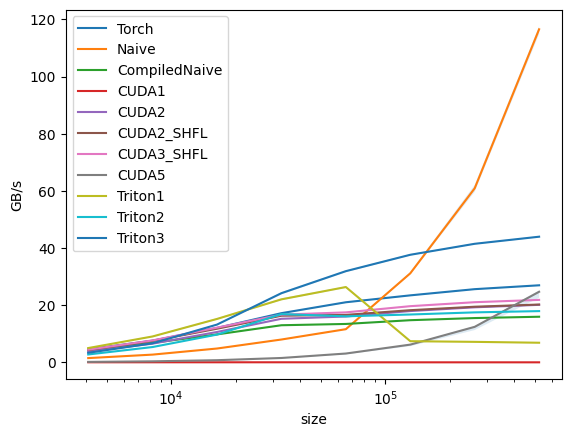

softmax-performance:
       size      Torch       Naive  CompiledNaive     CUDA1      CUDA2  CUDA2_SHFL  CUDA3_SHFL      CUDA5    Triton1    Triton2    Triton3
0    4096.0   4.612613    1.530643       4.357447  0.069960   3.806691    4.376068    4.491228   0.204004   5.044335   2.797814   3.379538
1    8192.0   7.641791    2.752688       6.849498  0.070428   6.585209    7.557196    7.728302   0.404383   9.102222   5.403694   6.714754
2   16384.0  12.082596    4.882002       9.822542  0.070678  10.666666   11.804035   12.190476   0.797896  15.226765   9.752381  13.255664
3   32768.0  17.246315    8.031373      13.023847  0.070709  15.283582   16.351298   16.718367   1.573267  22.080862  16.925620  24.236685
4   65536.0  21.059126   11.644634      13.473685  0.059849  16.078509   16.650406   17.522994   3.129106  26.383252  16.141871  31.937621
5  131072.0  23.472779   31.177927      14.787003  0.055697  17.984632   18.285714   19.692308   6.246878   7.442198  16.778290  37.664368
6  262

In [23]:
triton_softmax_benchmark.run(print_data=True, show_plots=True)

In [24]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 30, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=["CUDA5", "Naive"],  # Possible values for `line_arg`.
        line_names=["CUDA5", "Naive"],  # Label name for the lines.
        # styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('pink', '-'), ('yellow', '-'), ('black', '-'), ('orange', '-'), ('purple', '-'), ('cyan', '-'), ('gray', '-'), ('gray', '--')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='softmax-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def triton_softmax_benchmark(size, provider):
    x = torch.rand((1, size), device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: kernels[provider](x), quantiles=quantiles)
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

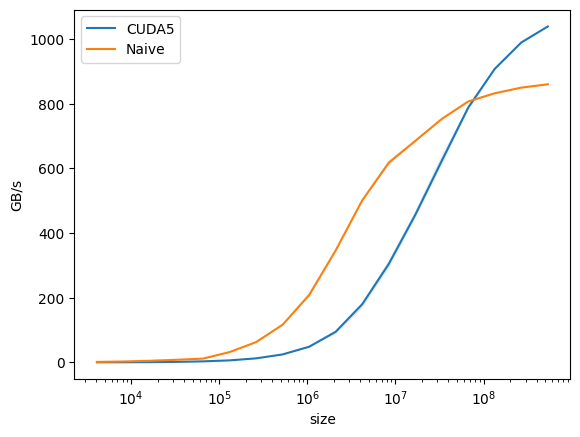

softmax-performance:
           size        CUDA5       Naive
0        4096.0     0.201734    1.490539
1        8192.0     0.403706    2.756393
2       16384.0     0.798518    4.976914
3       32768.0     1.563657    8.019579
4       65536.0     3.114533   11.652916
5      131072.0     6.209000   31.844508
6      262144.0    12.461684   62.713873
7      524288.0    24.632965  116.508449
8     1048576.0    48.464411  208.050786
9     2097152.0    94.653908  346.293262
10    4194304.0   179.858657  500.991853
11    8388608.0   304.221659  617.717819
12   16777216.0   456.349042  685.231846
13   33554432.0   623.781085  753.219699
14   67108864.0   788.755146  807.470380
15  134217728.0   908.497115  832.750497
16  268435456.0   989.945005  850.248816
17  536870912.0  1039.504720  860.502450


In [25]:
triton_softmax_benchmark.run(print_data=True, show_plots=True)